# Vehicle detection and tracking

The goals / steps of this project are the following:
* Extract HOG and color features of images in training set
* Train SVM classifier with HOG and color features
* Use slide window search to detect vehicles
* Generate video which detect and track vehicles

In [1]:
# Use logger to show info and debug
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG) #logging.INFO logging.DEBUG
if logger.handlers == []:
    ch = logging.StreamHandler()
    logger.addHandler(ch)

## Extract features and train classifier

### Load data for classifier training and validation

In [2]:
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import pickle
import time

def load_image(path):
    files = glob.glob(path)
    logger.debug('{} {}'.format(path, np.shape(files)))
    images = [mpimg.imread(x) for x in files]
    return images

if "non_vehicle.p" in os.listdir(".") and "vehicle.p" in os.listdir("."):
    logger.info('Use pickle file to load data')
else:
    logger.info('Load data from raw images')
    start = time.time()

    # Load non-vehicle images
    non_vehicle_images = []
    non_vehicle_images = np.array(load_image("non-vehicles/non-vehicles/Extras/*.png"))
    non_vehicle_images = np.append(non_vehicle_images, load_image("non-vehicles/non-vehicles/GTI/*.png"), axis=0)
    logger.info('non_vehicle_images {}'.format(np.shape(non_vehicle_images)))

    # Load vehicle images
    vehicle_images = []
    vehicle_images = np.array(load_image("vehicles/vehicles/GTI_Far/*.png"))
    vehicle_images = np.append(vehicle_images, load_image("vehicles/vehicles/GTI_Left/*.png"), axis=0)
    vehicle_images = np.append(vehicle_images, load_image("vehicles/vehicles/GTI_MiddleClose/*.png"), axis=0)
    vehicle_images = np.append(vehicle_images, load_image("vehicles/vehicles/GTI_Right/*.png"), axis=0)
    vehicle_images = np.append(vehicle_images, load_image("vehicles/vehicles/KITTI_extracted/*.png"), axis=0)
    logger.info('vehicle_images {}'.format(np.shape(vehicle_images)))

    end = time.time()
    logger.info('Spend {:.1f} seconds to load all vehicle and non-vehicle images'.format(end - start))

Use pickle file to load data


In [3]:
# Use pickle to retrieve training data faster in the next run
if "non_vehicle.p" not in os.listdir("."):
    pickle.dump(non_vehicle_images, open("non_vehicle.p", "wb"))

if "vehicle.p" not in os.listdir("."):
    pickle.dump(vehicle_images, open("vehicle.p", "wb"))
    
start = time.time()

non_vehicle_images = pickle.load(open("non_vehicle.p", "rb"))
logger.info('non_vehicle_images {}'.format(np.shape(non_vehicle_images)))
vehicle_images = pickle.load(open("vehicle.p", "rb"))
logger.info('vehicle_images {}'.format(np.shape(vehicle_images)))

end = time.time()
logger.info('Pickle only spends {:.1f} seconds to load all vehicle and non-vehicle images'.format(end - start))

non_vehicle_images (8968, 64, 64, 3)
vehicle_images (8792, 64, 64, 3)
Pickle only spends 1.0 seconds to load all vehicle and non-vehicle images


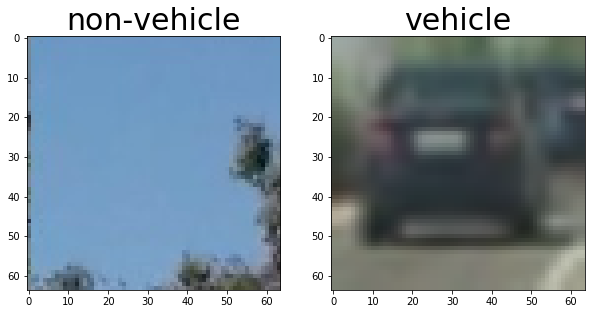

In [4]:
# Show one vehicle example and one non-vehicle example
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(non_vehicle_images[0])
ax1.set_title('non-vehicle', fontsize=30)
ax2.imshow(vehicle_images[0])
ax2.set_title('vehicle', fontsize=30)
plt.show()

### Extract HOG feature